<h1><center> DEEP Q NETWORKS WITH KERAS </center></h1>
<h2><center> ACTOR-CRITIC MODELS </center></h2>

This section comes from **Roman Ring, (2020), `Deep Reinforcement Learning With TensorFlow 2.1`**. The reference can be found at:

http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/

## 1. CONTEXT: COMPLEX SPACES WITH A CONTINUM OF STATES

Reinforcement Learning
Generally speaking, reinforcement learning is a high-level framework for solving sequential decision-making problems. An RL agent navigates an environment by taking actions based on some observations, receiving rewards as a result. Most RL algorithms work by maximizing the expected total rewards an agent collects in a trajectory, e.g., during one in-game round.

The output of an RL algorithm is a policy – a function from states to actions.
A valid policy can be as simple as a hard-coded no-op action, but typically it represents a conditional probability distribution of actions given some state.

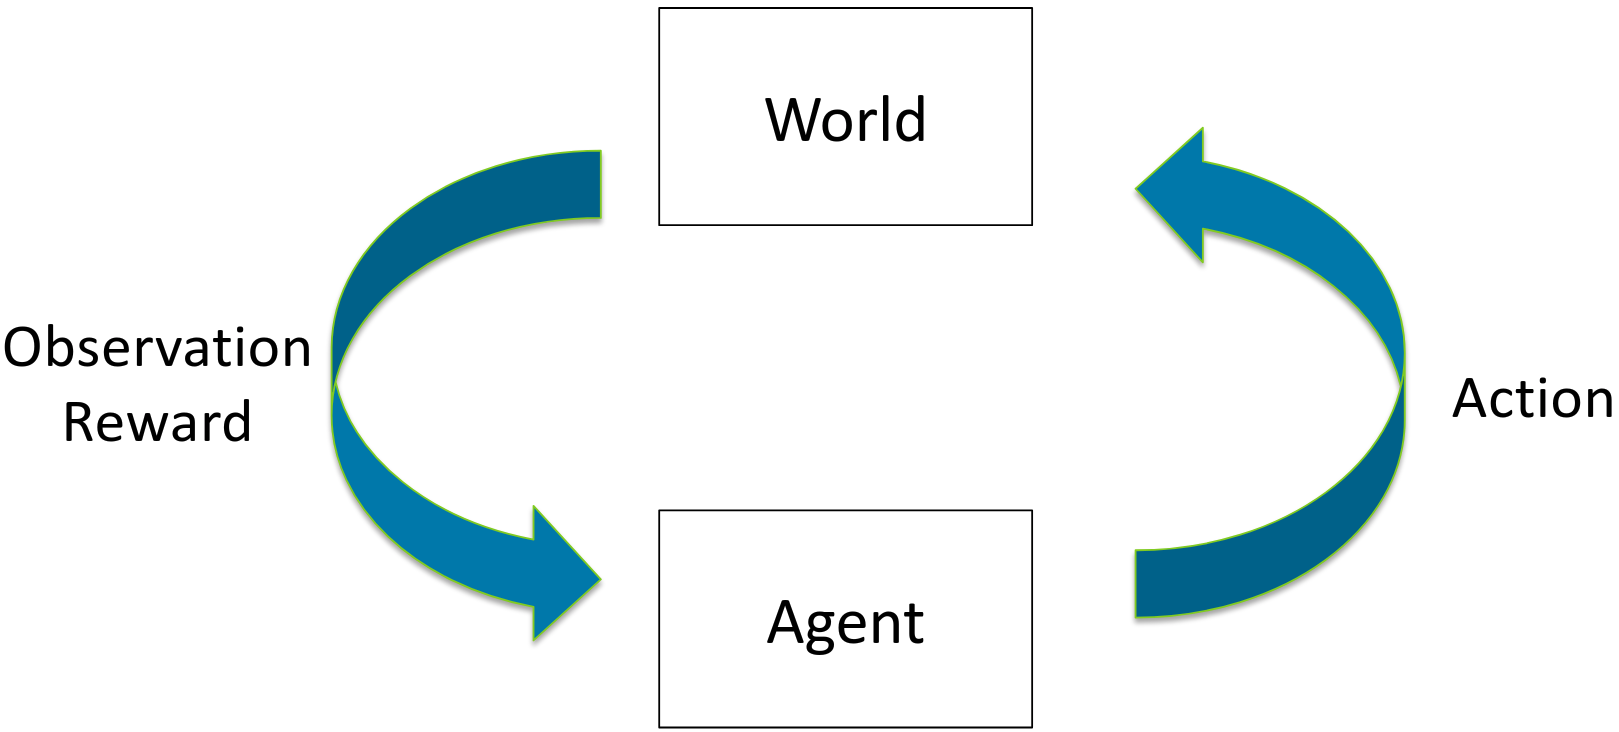

RL algorithms are often grouped based on their optimization loss function.

> - Temporal-Difference methods, such as Q-Learning, reduce the error between predicted and actual state(-action) values.

> - Policy Gradients directly optimize the policy by adjusting its parameters. Calculating gradients themselves is usually infeasible; instead, they are often estimated via monte-carlo methods.

The most popular approach is a hybrid of the two: actor-critic methods, where policy gradients optimize agent’s policy, and the temporal-difference method is used as a bootstrap for the expected value estimates.

### DEEP REINFORCEMENT LEARNING

While much of the fundamental RL theory was developed on the tabular cases, modern RL is almost exclusively done with function approximators, such as artificial neural networks. Specifically, an RL algorithm is considered deep if the policy and value functions are approximated with neural networks.

**(Asynchronous) Advantage Actor-Critic**

Over the years, several improvements were added to address sample efficiency and stability of the learning process.

First, gradients are weighted with returns: a discounted sum of future rewards, which resolves theoretical issues with infinite timesteps, and mitigates the credit assignment problem – allocate rewards to the correct actions.

Second, an advantage function is used instead of raw returns. Advantage is formed as the difference between the returns and some baseline, which is often the value estimate, and can be thought of as a measure of how good a given action is compared to some average.

Third, an additional entropy maximization term is used in the objective function to ensure the agent sufficiently explores various policies. In essence, entropy measures how random a given probability distribution is. For example, entropy is highest in the uniform distribution.

Finally, multiple workers are used in parallel to speed up sample gathering while helping decorrelate them during training, diversifying the experiences an agent trains on in a given batch.

Incorporating all of these changes with deep neural networks, we arrive at the two of the most popular modern algorithms: (asynchronous) advantage actor critic, or A3C/A2C for short. The difference between the two is more technical than theoretical. As the name suggests, it boils down to how the parallel workers estimate their gradients and propagate them to the model.

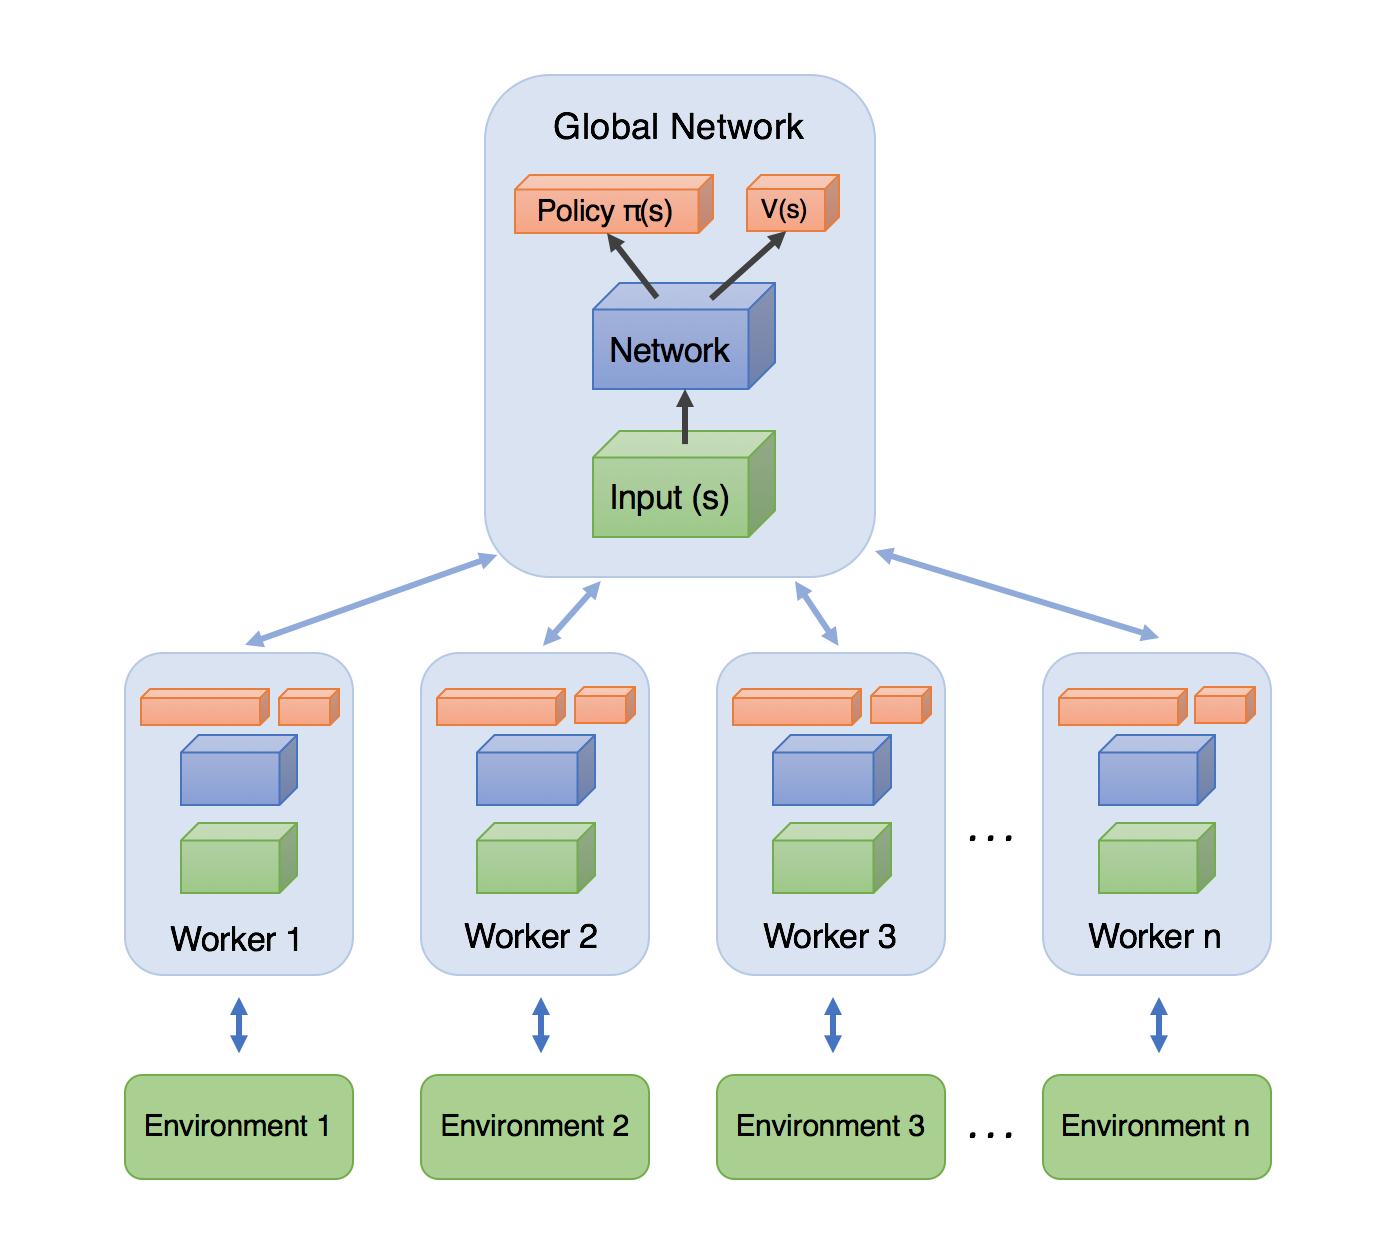

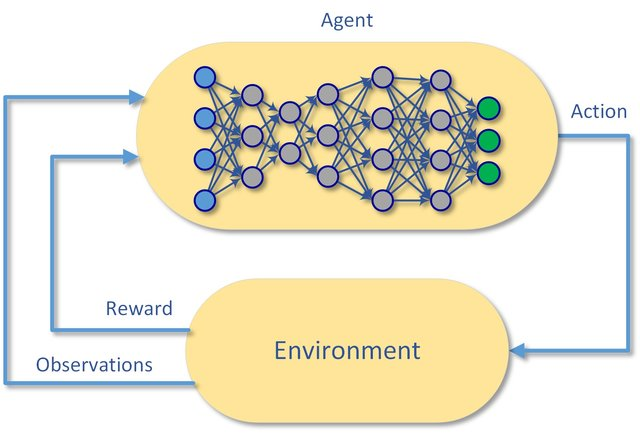

## 2. ADVANTAGE ACTOR-CRITIC MODEL


Now that we are more or less on the same page, let’s see what it takes to implement the basis of many modern DRL algorithms: an actor-critic agent, described in the previous section. Without parallel workers (for simplicity), though most of the code would be the same.

As a testbed, we are going to use the CartPole-v0 environment. Somewhat simplistic, it is still a great option to get started. In fact, I often rely on it as a sanity check when implementing RL algorithms.

**Policy & Value Models via Keras API**

First, we create the policy and value estimate NNs under a single model class:

Things to note here:

> - Model layers and execution path are defined separately
> - There is no “input” layer; model accepts raw numpy arrays
> - Two computation paths can exist in one model via functional API
> - A model can contain helper methods such as action sampling
> - In eager mode, everything works from raw numpy arrays

** Agent Interface** 

Now we can move on to the fun stuff – the agent class. First, we add a test method that runs through a full episode, keeping track of the rewards.

*Loss / Objective Function*

As I have described in the RL section, an agent improves its policy through gradient descent based on some loss (objective) function. In the A2C algorithm, we train on three objectives: improve policy with advantage weighted gradients, maximize the entropy, and minimize value estimate errors.

And we are done with the objective functions! Note how compact the code is: there are almost more comment lines than code itself.

*The Training Loop*

Finally, there is the train loop itself. It is relatively long, but fairly straightforward: collect samples, calculate returns and advantages, and train the model on them.

*Results*

We are now all set to train our single-worker A2C agent on CartPole-v0! The training process should take a couple of minutes. After the training is complete, you should see an agent achieve the target 200 out of 200 score.

http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/

https://github.com/inoryy/tensorflow2-deep-reinforcement-learning/blob/master/a2c.py


In [1]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [ ]:
restartkernel()

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
import gym
import logging
import matplotlib.pyplot as plt

class ProbabilityDistribution(tf.keras.Model):
  def call(self, logits, **kwargs):
    # Sample a random categorical action from the given logits.
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)


class Model(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__('mlp_policy')
        self.hidden1 = kl.Dense(128, activation='relu')
        self.hidden2 = kl.Dense(128, activation='relu')
        self.value = kl.Dense(1, name='value')
        self.logits = kl.Dense(num_actions, name='policy_logits')
        self.dist = ProbabilityDistribution()

    def call(self, inputs, **kwargs):
        x = tf.convert_to_tensor(inputs)
        hidden_logs = self.hidden1(x)
        hidden_vals = self.hidden2(x)
        return self.logits(hidden_logs), self.value(hidden_vals)

    def action_value(self, obs):
        logits, value = self.predict_on_batch(obs)
        action = self.dist.predict_on_batch(logits)
        return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

D:\Program Files\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class A2CAgent:
    def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
        # Coefficients are used for the loss terms.
        self.value_c = value_c
        self.entropy_c = entropy_c
        self.gamma = gamma

        self.model = model
        self.model.compile(
        optimizer=ko.RMSprop(lr=lr),
        loss=[self._logits_loss, self._value_loss])
        
        
    def train(self, env, batch_sz=64, updates=250):
        actions = np.empty((batch_sz,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch_sz))
        observations = np.empty((batch_sz,) + env.observation_space.shape)
        ep_rewards = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch_sz):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None, :])
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])
                ep_rewards[-1] += rewards[step]
                if dones[step]:
                    ep_rewards.append(0.0)
                    next_obs = env.reset()
                    logging.info("Episode: %03d, Reward: %03d" % (
                        len(ep_rewards) - 1, ep_rewards[-2]))

            _, next_value = self.model.action_value(next_obs[None, :])
            returns, advs = self._returns_advantages(rewards, dones, values, next_value)
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
            logging.debug("[%d/%d] Losses: %s" % (update + 1, updates, losses))

        return ep_rewards
 
    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        advantages = returns - values
        return returns, advantages      
        

    def test(self, env, render=True):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None, :])
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        return ep_reward

    def _value_loss(self, returns, value):
        return self.value_c * kls.mean_squared_error(returns, value)

    def _logits_loss(self, actions_and_advantages, logits):
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        probs = tf.nn.softmax(logits)
        entropy_loss = kls.categorical_crossentropy(probs, probs)
        return policy_loss - self.entropy_c * entropy_loss

In [3]:
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.INFO)

with tf.Graph().as_default():
    print("Eager Execution:", tf.executing_eagerly()) # False
    env = gym.make('CartPole-v0')
    model = Model(num_actions=env.action_space.n)
    agent = A2CAgent(model)

    rewards_history = agent.train(env)
    print("Finished training! Testing...")
    print("Total Episode Reward: %d out of 200" % agent.test(env))
env.close()

Eager Execution: False


D:\Program Files\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:root:Episode: 001, Reward: 019
INFO:root:Episode: 002, Reward: 021
INFO:root:Episode: 003, Reward: 019
INFO:root:Episode: 004, Reward: 038
INFO:root:Episode: 005, Reward: 017
INFO:root:Episode: 006, Reward: 030
INFO:root:Episode: 007, Reward: 020
INFO:root:Episode: 008, Reward: 012
INFO:root:Episode: 009, Reward: 025
INFO:root:Episode: 010, Reward: 019
INFO:root:Episode: 011, Reward: 024
INFO:root:Episode: 012, Reward: 009
INFO:root:Episode: 013, Reward: 019
INFO:root:Episode: 014, Reward: 024
INFO:root:Episode: 015, Reward: 025
INFO:root:Episode: 016, Reward: 034
INFO:root:Episode: 017, Reward: 011
INFO:root:Episode: 018, Reward: 027
INFO:root:Episode: 019, Reward: 023
INFO:root:Episode: 020, Reward: 033
INFO:root:Episode: 021, Reward: 016
INFO:root:Episode: 022, Reward: 027
INFO:root:Episode: 023, Reward: 048
INFO:root:Episode: 024, Reward: 024
INFO:root:Episode: 025, Reward: 057
INFO:root:Episode: 026, Reward: 047
INFO:root:Episode: 027, Reward: 015
INFO:root:Episode: 028, Rewa

Finished training! Testing...
Total Episode Reward: 200 out of 200


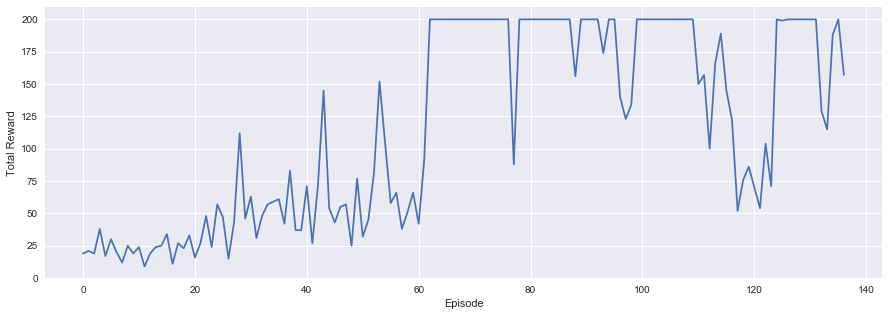

In [4]:
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(rewards_history)
#plt.plot(np.arange(0, len(rewards_history), 5), rewards_history[::5])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()